In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
two_gpts = [-1/(np.sqrt(3)), 1/(np.sqrt(3))]
two_wts = [1,1]
three_gpts = [0, np.sqrt(3/5), -np.sqrt(3/5)]
three_wts = [8/9, 5/9, 5/9]

In [3]:
def find_KR(stencil, gpts, wts):
    
    n_ele = len(stencil)-1
    KR = np.zeros((n_ele+1,n_ele+1))

    for i in range(n_ele):
        coords = stencil[i:i+2]
        dN = np.array([-0.5,0.5])[np.newaxis,:]
        Jac = dN @ coords
        for j in range(len(gpts)):
            N = np.array([(1-gpts[j])/2, (1+gpts[j])/2])[np.newaxis,:]
            X = N @ coords
            kr = (dN.T @ dN)*(float(X)**2)*wts[j]*(1/float(Jac))
            #Assemble to KR
            KR[i:i+2,i:i+2] += kr
               
    return KR

In [4]:
def find_MR(stencil, gpts, wts):
    
    n_ele = len(stencil)-1
    MR = np.zeros((n_ele+1,n_ele+1))

    for i in range(n_ele):
        coords = stencil[i:i+2]
        dN = np.array([-0.5,0.5])[np.newaxis,:]
        Jac = dN @ coords
        for j in range(len(gpts)):
            N = np.array([(1-gpts[j])/2, (1+gpts[j])/2])[np.newaxis,:]
            X = N @ coords
            mr = (N.T @ N)*(float(X)**2)*wts[j]*(float(Jac))
            #Assemble to MR
            MR[i:i+2,i:i+2] += mr
               
    return MR

In [5]:
def find_KCR(stencil, gpts, wts, C_t):

    n_ele = len(stencil)-1
    KCR = np.zeros((n_ele+1,n_ele+1))
    
    for i in range(n_ele):
        coords = stencil[i:i+2]
        dN = np.array([-0.5,0.5])[np.newaxis,:]
        Jac = dN @ coords
        for j in range(len(gpts)):
            N = np.array([(1-gpts[j])/2, (1+gpts[j])/2])[np.newaxis,:]
            C = N @ C_t[i:i+2]
            X = N @ coords
            kcr = C*(dN.T @ dN)*(float(X)**2)*wts[j]*(1/float(Jac))
            #Assemble to KCR
            KCR[i:i+2,i:i+2] += kcr
    
    return KCR

In [6]:
r_o = 5e-6
time = 1e3
R = 8.314
T = 298
mol_vol = 3.49e-6
E = 1e10
nu = 0.3
theta = (2*(mol_vol**2)*E)/(9*(1-nu)*R*T)
i = 2
F = 96487
D = 7.08e-15
bc = (i/F)*(r_o**2)

### Mesh Convergence

In [7]:
nodal_points = [1e-6, 2e-6, 4e-6]
nodes = [11, 21, 51, 101, 201]
delt = 10
C_at_r = []
C_ws_at_r = []
for node in nodes:
    stencil = np.linspace(0, r_o, node)
    BC = np.zeros(node)
    BC[-1] = bc

    counter  = 0
    tol = 1e-6
    C_t = np.array([0]*node)
    MR = find_MR(stencil, two_gpts, two_wts)
    KR = find_KR(stencil, two_gpts, two_wts)

    while(counter < int(time/delt)):#time marching

        temp = C_t
        error = np.inf
        #piccard
        while(error > tol):

            KCR = find_KCR(stencil, two_gpts, two_wts, temp)
            C_t_1 = np.linalg.solve(MR + delt*D*(KR + theta*KCR), delt*(BC) + MR@C_t)
            error = np.linalg.norm(C_t_1 - temp,2)
            temp = C_t_1
        
        C_t = C_t_1
        counter += 1

    # Map nodal_points to the indices of the stencil
    indices = [np.abs(stencil - point).argmin() for point in nodal_points]
    C_at_r.append(C_t[indices])  # Append concentration at nodal points

    counter  = 0
    C_t = np.array([0]*node)
    inv = np.linalg.inv(MR + delt*D*KR)

    while(counter < int(time/delt)):#time marching

        C_t_1 = inv@(delt*(BC) + MR@C_t)
        C_t = C_t_1
        counter += 1
    
    C_ws_at_r.append(C_t[indices])  # Append concentration at nodal points

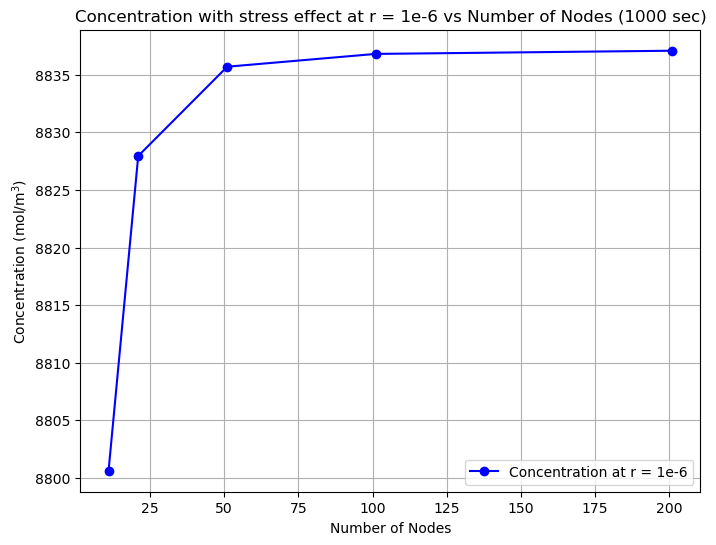

In [8]:
# Extract the first entries of the `C_at_r` list
first_entries = [entry[0] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, first_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 1e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title('Concentration with stress effect at r = 1e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

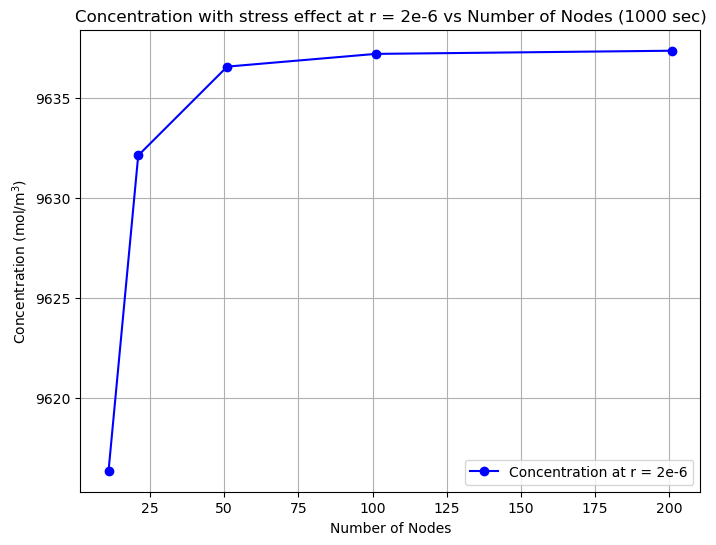

In [9]:
# Extract the first entries of the `C_at_r` list
second_entries = [entry[1] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, second_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 2e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title('Concentration with stress effect at r = 2e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

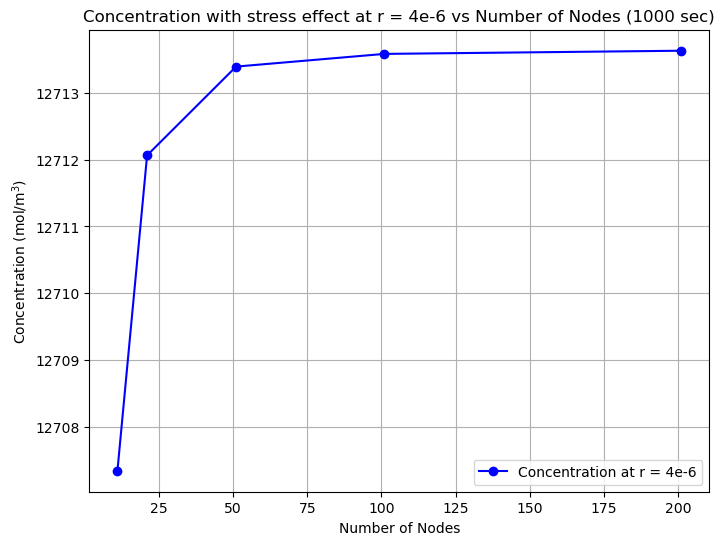

In [10]:
# Extract the first entries of the `C_at_r` list
third_entries = [entry[2] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, third_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 4e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$) ')
plt.title('Concentration with stress effect at r = 4e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

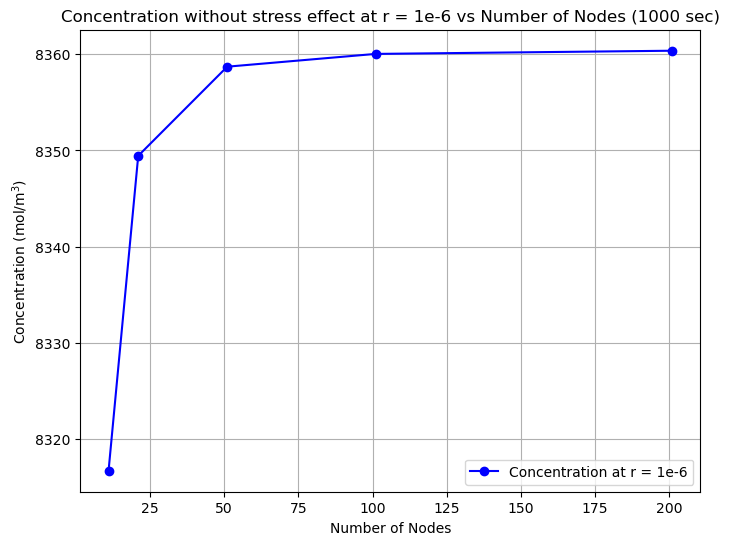

In [11]:
# Extract the first entries of the `C_at_r` list
first_entries = [entry[0] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, first_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 1e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title('Concentration without stress effect at r = 1e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

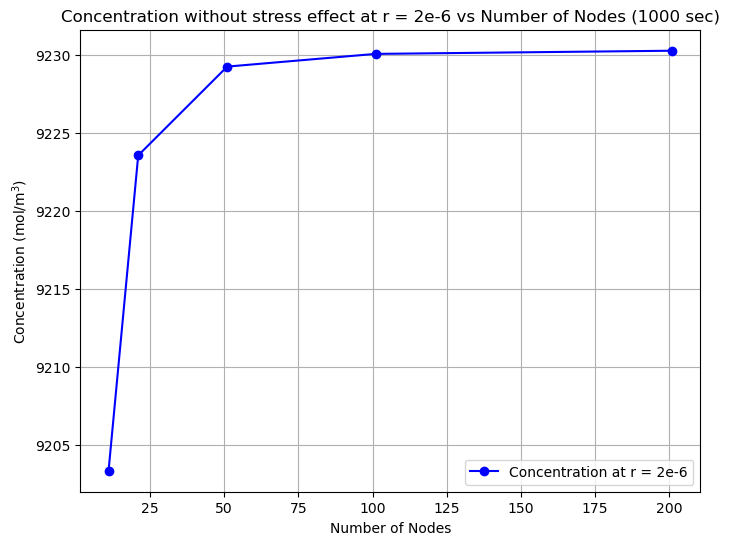

In [12]:
# Extract the first entries of the `C_at_r` list
second_entries = [entry[1] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, second_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 2e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title('Concentration without stress effect at r = 2e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

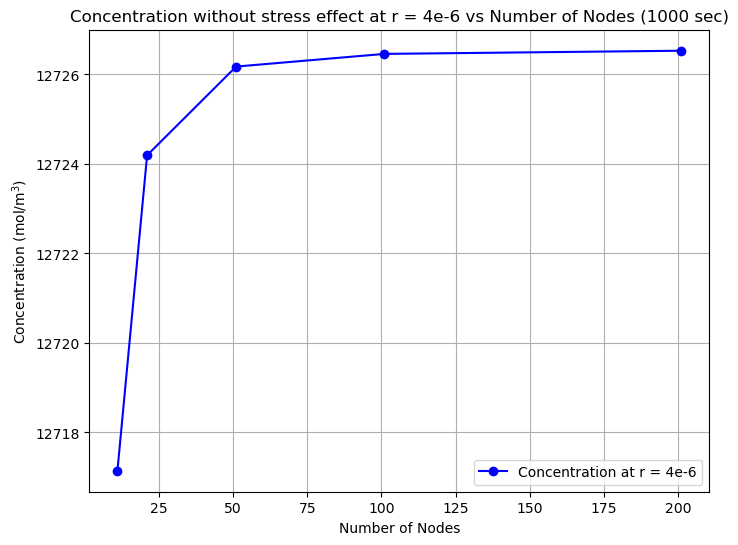

In [13]:
# Extract the first entries of the `C_at_r` list
third_entries = [entry[2] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.plot(nodes, third_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 4e-6')
plt.xlabel('Number of Nodes')
plt.ylabel(r'Concentration ($\text{mol/m}^3$) ')
plt.title('Concentration without stress effect at r = 4e-6 vs Number of Nodes (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

### Time Convergence

In [14]:
nodal_points = [1e-6, 2e-6, 4e-6]
DELT = [100, 10, 1, 1e-1]
n_nodes = 101
stencil = np.linspace(0, r_o, n_nodes)
MR = find_MR(stencil, two_gpts, two_wts)
KR = find_KR(stencil, two_gpts, two_wts)

BC = np.zeros(n_nodes)
BC[-1] = bc

C_at_r = []
C_ws_at_r = []

for delt in DELT:
    
    counter  = 0
    tol = 1e-6
    C_t = np.array([0]*n_nodes)
   
    while(counter < int(time/delt)):#time marching

        temp = C_t
        error = np.inf
        #piccard
        while(error > tol):

            KCR = find_KCR(stencil, two_gpts, two_wts, temp)
            C_t_1 = np.linalg.solve(MR + delt*D*(KR + theta*KCR), delt*(BC) + MR@C_t)
            error = np.linalg.norm(C_t_1 - temp,2)
            temp = C_t_1
        
        C_t = C_t_1
        counter += 1

    # Map nodal_points to the indices of the stencil
    indices = [np.abs(stencil - point).argmin() for point in nodal_points]
    C_at_r.append(C_t[indices])  # Append concentration at nodal points

    counter  = 0
    C_t = np.array([0]*n_nodes)
    inv = np.linalg.inv(MR + delt*D*KR)

    while(counter < int(time/delt)):#time marching

        C_t_1 = inv@(delt*(BC) + MR@C_t)
        C_t = C_t_1
        counter += 1
    
    C_ws_at_r.append(C_t[indices])  # Append concentration at nodal points

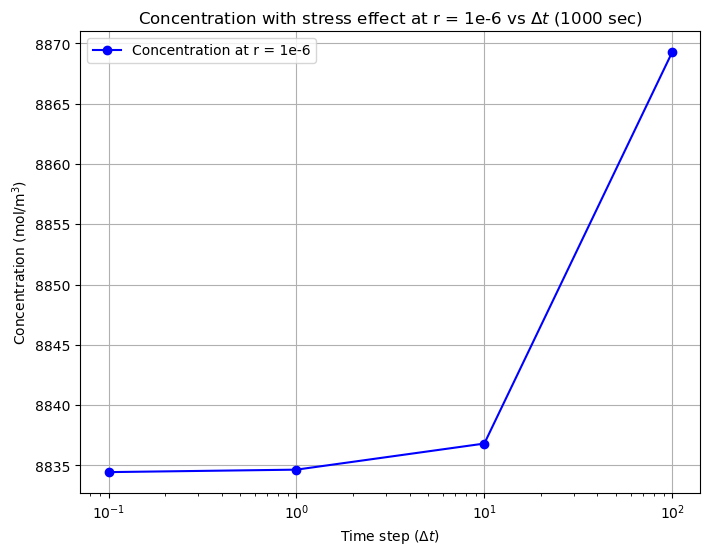

In [15]:
# Extract the first entries of the `C_at_r` list
first_entries = [entry[0] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, first_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 1e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration with stress effect at r = 1e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

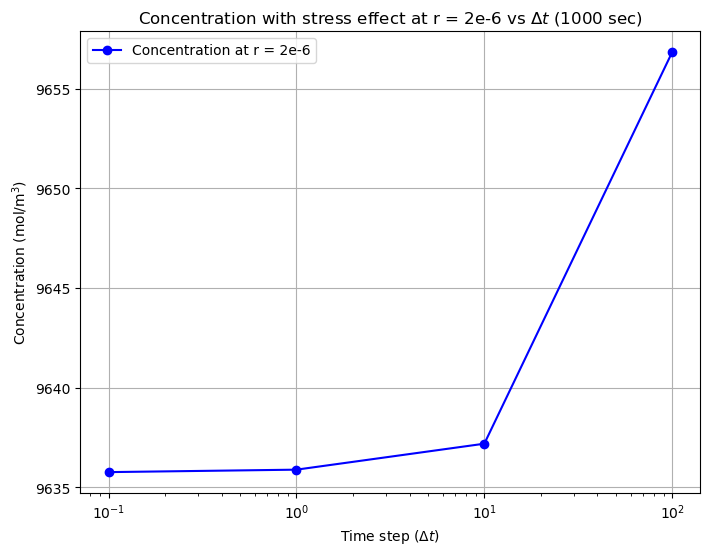

In [16]:
# Extract the first entries of the `C_at_r` list
second_entries = [entry[1] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, second_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 2e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration with stress effect at r = 2e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

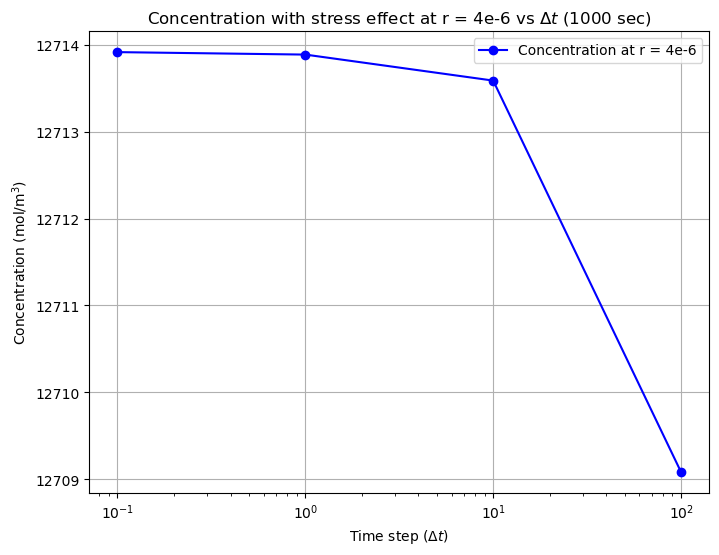

In [17]:
# Extract the first entries of the `C_at_r` list
third_entries = [entry[2] for entry in C_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, third_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 4e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration with stress effect at r = 4e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

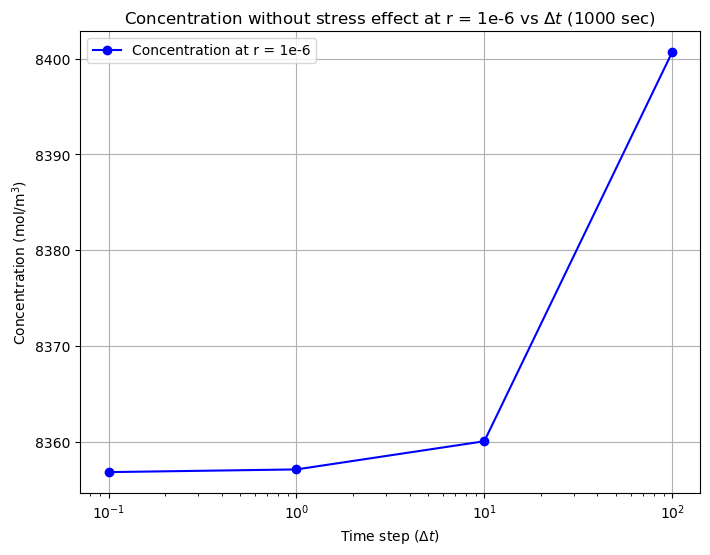

In [18]:
# Extract the first entries of the `C_at_r` list
first_entries = [entry[0] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, first_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 1e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration without stress effect at r = 1e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

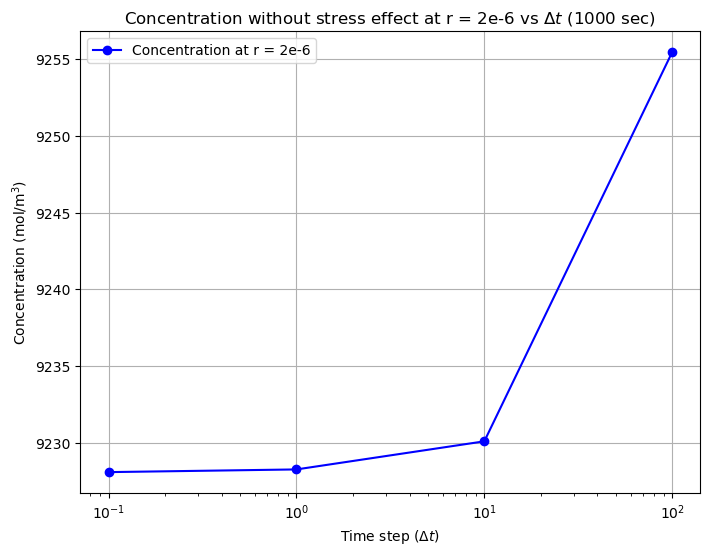

In [19]:
# Extract the first entries of the `C_at_r` list
second_entries = [entry[1] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, second_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 2e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration without stress effect at r = 2e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

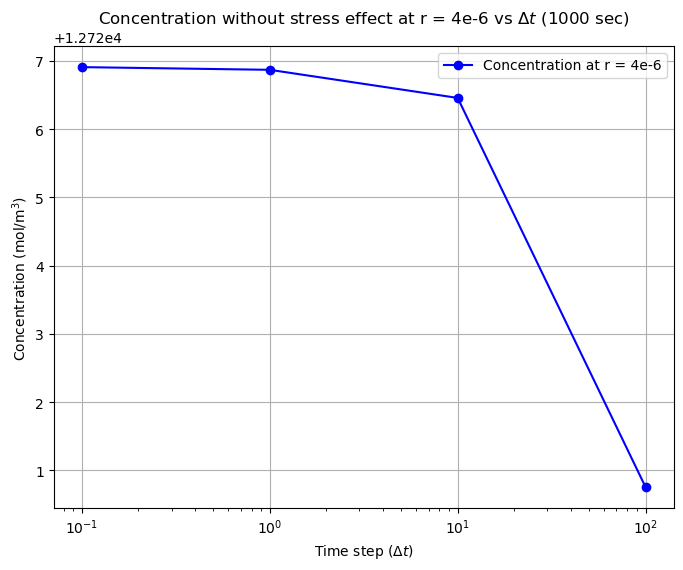

In [20]:
# Extract the first entries of the `C_at_r` list
third_entries = [entry[2] for entry in C_ws_at_r]

# Plot `nodes` vs `first_entries`
plt.figure(figsize=(8, 6))
plt.semilogx(DELT, third_entries, marker='o', linestyle='-', color='b', label='Concentration at r = 4e-6')
plt.xlabel(r'Time step ($\Delta t$)')
plt.ylabel(r'Concentration ($\text{mol/m}^3$)')
plt.title(r'Concentration without stress effect at r = 4e-6 vs $\Delta t$ (1000 sec)')
plt.grid(True)
plt.legend()
plt.show()

### Results Comparison

In [21]:
BC = np.zeros(n_nodes)
BC[-1] = bc

n_nodes = 101
delt = 1
stencil = np.linspace(0, r_o, n_nodes)

In [22]:
C_global = []
counter  = 0
tol = 1e-6
C_t = np.array([0]*n_nodes)
MR = find_MR(stencil, two_gpts, two_wts)
KR = find_KR(stencil, two_gpts, two_wts)

while(counter < int(time/delt)):#time marching

    temp = C_t
    error = np.inf
    #piccard
    while(error > tol):

        KCR = find_KCR(stencil, two_gpts, two_wts, temp)
        C_t_1 = np.linalg.solve(MR + delt*D*(KR + theta*KCR), delt*(BC) + MR@C_t)
        error = np.linalg.norm(C_t_1 - temp,2)
        temp = C_t_1
    

    C_t = C_t_1
    counter += 1

    if (counter % 100 == 0):
        C_global.append(C_t)

In [23]:
C_ws_global = [] #without stress
counter  = 0
C_t = np.array([0]*n_nodes)
MR = find_MR(stencil, two_gpts, two_wts)
KR = find_KR(stencil, two_gpts, two_wts)

inv = np.linalg.inv(MR + delt*D*KR)

while(counter < int(time/delt)):#time marching

    C_t_1 = inv@(delt*(BC) + MR@C_t)
    C_t = C_t_1
    counter += 1

    if (counter % 100 == 0):
        C_ws_global.append(C_t)

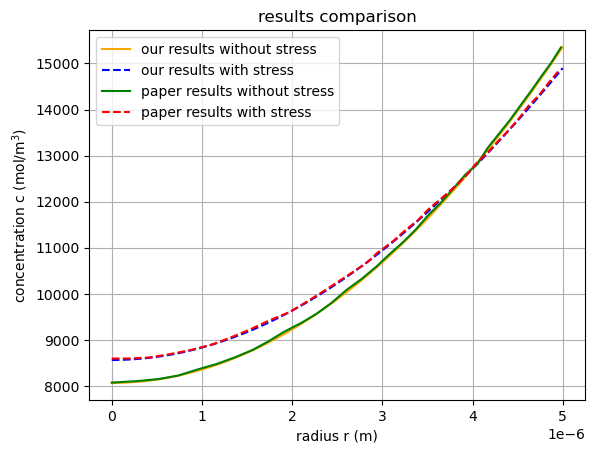

In [24]:
# Replace 'file.csv' with the path to your CSV file
with_stress = pd.read_csv('paper_withstress.csv', header = None)
without_stress = pd.read_csv('paper_withoutstress.csv', header = None)
# Extract the x and y columns
x_withoutstress = without_stress[0]
y_withoutstress = without_stress[1]

x_withstress = with_stress[0]
y_withstress = with_stress[1]

# Plot your data
plt.plot(stencil, C_ws_global[-1], label='our results without stress', color='orange')
plt.plot(stencil, C_global[-1], label='our results with stress', linestyle='--', color='blue')

# # Plot the CSV data
plt.plot(x_withoutstress, y_withoutstress, label='paper results without stress', color='green')
plt.plot(x_withstress, y_withstress, label='paper results with stress', linestyle='--', color='red')

# Add labels, title, and legend
plt.xlabel('radius r (m)')
plt.ylabel(r'concentration c ($\text{mol/m}^3$)')
plt.title('results comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### 2D Heatmap

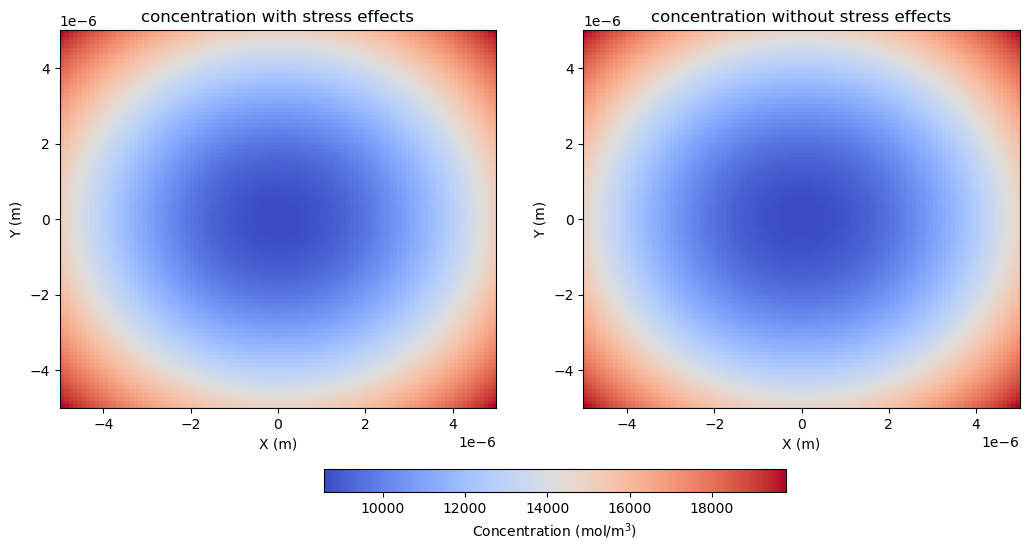

In [25]:
# Create the mesh grid for plotting
x = np.linspace(-5e-6, 5e-6, 101)
y = np.linspace(-5e-6, 5e-6, 101)
X, Y = np.meshgrid(x, y)

# Calculate the radial distance r for each point on the grid
R = np.sqrt(X**2 + Y**2)

# Interpolate the concentration values for each grid point
interp_concentration = interp1d(stencil, C_global[-1], bounds_error=False, fill_value="extrapolate")
interp_concentration_ws = interp1d(stencil, C_ws_global[-1], bounds_error=False, fill_value="extrapolate")

# Get the concentration values on the grid for both C_global and C_ws_global
concentration_grid_global = interp_concentration(R)
concentration_grid_ws = interp_concentration_ws(R)

# Create a figure with specific canvas size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot C_global[-1] on ax1
cax1 = ax1.imshow(concentration_grid_global, extent=[-5e-6, 5e-6, -5e-6, 5e-6], origin='lower', cmap='coolwarm', aspect='auto')
ax1.set_title('concentration with stress effects')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

# Plot C_ws_global[-1] on ax2
cax2 = ax2.imshow(concentration_grid_ws, extent=[-5e-6, 5e-6, -5e-6, 5e-6], origin='lower', cmap='coolwarm', aspect='auto')
ax2.set_title('concentration without stress effects')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')

# Add a colorbar beneath both subplots, use a horizontal colorbar
cbar = fig.colorbar(cax1, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label(r'Concentration ($\text{mol/m}^3$)')

# Adjust layout to make sure the plots and colorbar fit without overlap
plt.subplots_adjust(bottom=0.25, left=0.1, right=0.9)
plt.show()